In [7]:
import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [8]:
font = {'size': 14}
axislabelfontsize='large'
matplotlib.rc('font', **font)

# The PyBird Correlator Class

**PyBird** computes EFT predictions for correlators of density fields: in real space or redshift space (multipoles), of dark matter or biased tracers, in Fourier (power spectrum) or configuration space (correlation function).  
What and how we want **PyBird** to perform such computation is communicated through the `Correlator()` class.  

In [11]:
from pybird.correlator import Correlator
from pybird.symbolic import Symbolic

### Setting the linear cosmology

Redshift?

In [12]:
z = 0.57

First, we create a **Symbolic** Engine `M`, that will be provided to the **PyBird** Correlator Engine. 

In [13]:
z = 0.57
kk = np.logspace(-5, 0, 500)
cosmo = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}

# Initialize Symbolic cosmology class
M = Symbolic()
M.set(cosmo)
M.compute(kk, z)
pk_lin = M.pk_lin
D1, f1 = M.D, M.f  # Growth factor and growth rate

All what **PyBird** needs is a linear cosmology, e.g., a linear power spectrum `pklin` and the $k$-array on which it is provided, `kk`.  
In redshift space, we will also need to provide the growth rate `f1`. 

That's all. 

Oh, and let us specify a $k$-array (or $s$-array for configuration space) on which we want to have the EFT prediction evaluated. 

In [14]:
dk, ds = 0.01, 5
kd = np.arange(0.005, 0.3, dk)
sd = np.arange(10, 200, ds)

### Setting the Pybird Correlator class

We create a **PyBird** Correlator Engine `N`.

In [15]:
N = Correlator()

Next, we specify what we want to PyBird to compute for us.  

We can see what can be specified with the following command. 

In [16]:
N.info()



Configuration commands [.set(config_dict)]
----------------------
'output': ['str'] ; options: ['bPk', 'bCf', 'mPk', 'mCf', 'bmPk', 'bmCf']
    - Correlator: biased tracers / matter / biased tracers-matter -- power spectrum / correlation function.
    * default: bPk
'multipole': ['int'] ; options: [0, 2, 3]
    - Number of multipoles. 0: real space. 2: monopole + quadrupole. 3: monopole + quadrupole + hexadecapole.
    * default: 2
'z': ['float']
    - Effective redshift.
    * default: None
'km': ['float']
    - Inverse tracer spatial extension scale in [h/Mpc].
    * default: 0.7
'kr': ['float']
    - Inverse velocity product renormalization scale in [h/Mpc].
    * default: 0.25
'nd': ['float']
    - Mean galaxy density
    * default: 0.0003
'kmin': ['float']
    - kmin in [h/Mpc] for 'output': '_Pk', to be chosen between [1e-4, 1e-3]. 
    * default: 0.001
'kmax': ['float']
    - kmax in [h/Mpc] for 'output': '_Pk'
    * default: 0.25
'with_bias': ['bool']
    - Bias (in)dependent

#### Dark matter in real space

Let us start with dark matter in real space. 

In [17]:
N.set({'output': 'mPk', 'multipole': 0, 'kmax': 0.3, 'xdata': kd, 'with_bias': False}) 

The first time we ask **PyBird** to do a specific computation, it will generate loop matrices according the FFTLog of the linear power spectrum, see e.g., App. A of [2110.07539](https://arxiv.org/abs/2110.07539) , and save them.  
The next time, it will simply load the matrices, and the call to this computation setup will be much faster. 

Now let **PyBird** compute. 

In [18]:
N.compute({'kk': kk, 'pk_lin': pk_lin})

We can now get the matter power spectrum: 

In [19]:
mPk = N.get({'cct': 1})

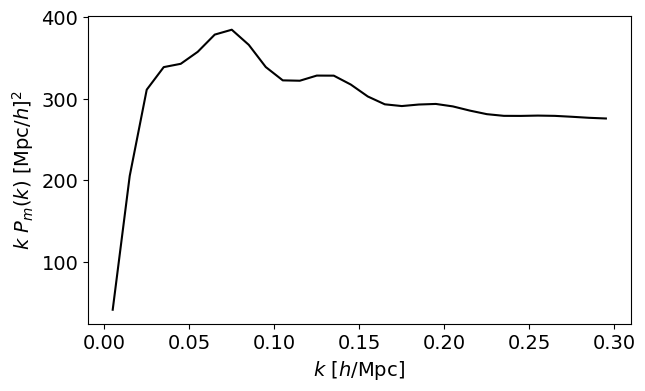

In [20]:
plt.figure(figsize=(7,4))
plt.plot(kd, kd * mPk[0], 'k')
plt.xlabel(r'$k \ [h/{\rm Mpc}]$')
plt.ylabel(r'$k \ P_m(k) \ [{\rm Mpc}/h]^2$')
plt.show()

As you may have noticed, communicating with **PyBird** Correlator Engine is very similar to the **CLASS** Engine. 

#### Biased tracers in redshift space

Let us now turn to biased tracers in redshift space.

We load some fiducial EFT parameters from a previous fit. 

In [23]:
eft_params = {
    'b1': 1.95, 'b2': 0.41, 'b3': -0.36, 'b4': 0.41,
    'cct': 0.18, 'cr1': -0.84, 'cr2': -0.81,
    'ce0': 1.50, 'ce1': 0.0, 'ce2': -1.63
}

Now let us make the **PyBird** Correlator Engine compute: 

In [24]:
N = Correlator()

N.set({'output': 'bPk', 'multipole': 3, 'kmax': 0.3, 'xdata': kd, 
       'km': 0.7, 'kr': 0.35, 'nd': 3e-4,           # these scales control the various EFT expansions...
       'eft_basis': 'eftoflss', 'with_stoch': True, # there are various equivalent EFT parametrization one can choose
       'with_bias': False}) 

N.compute({'kk': kk, 'pk_lin': pk_lin, 'f': f1, # here we also pass the growth rate f since we are now in redshift space
           }) 

bPk = N.get(eft_params)

The scales controlling the various EFT expansions are well described in [2210.14931](https://arxiv.org/abs/2210.14931) (see also [2110.00016](https://arxiv.org/abs/2110.00016)).

There are various equivalent basis for the EFT parameters that are implemented in **PyBird** (see `Correlator.info()`).  
Those are described in e.g., [2208.05929](https://arxiv.org/abs/2208.05929).  
For each basis, you can find the EFT parameter names recognized by **PyBird** in https://github.com/pierrexyz/pybird/tree/v1.1/data/eftboss/config

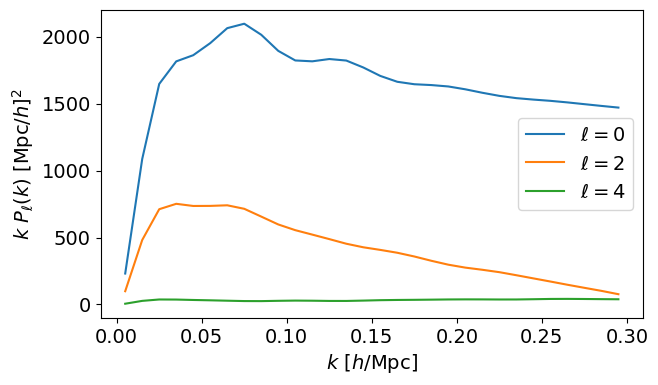

In [25]:
plt.figure(figsize=(7,4))
for i in range(3): plt.errorbar(kd, kd * bPk[i], label=r'$\ell=%s$' % (2*i))
plt.xlabel(r'$k \ [h/{\rm Mpc}]$')
plt.ylabel(r'$k \ P_\ell(k) \ [{\rm Mpc}/h]^2$')
plt.legend()
plt.show()

#### Configuration space

Finally, let us compute the multipoles of the correlation function of biased tracers. 

In [26]:
N = Correlator()

N.set({'output': 'bCf', 'multipole': 3, 'kmax': 0.3, 'xdata': sd, 'km': 0.7, 'kr': 0.35,
       'eft_basis': 'eftoflss', 'with_bias': False, 'with_resum': False})          # there is no stochastic term in configuration space, see 2110.07539

N.compute({'kk': kk, 'pk_lin': pk_lin, 'f': f1}) 

bCf = N.get(eft_params)

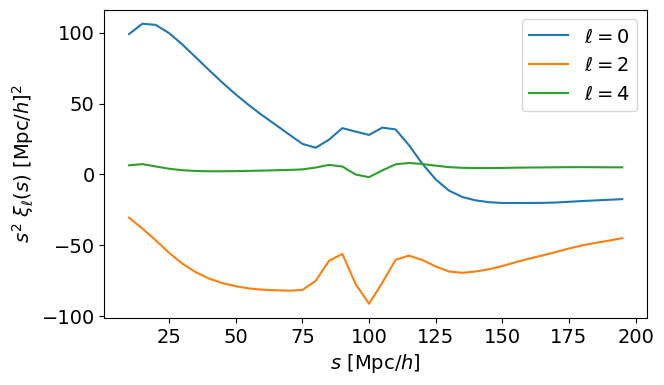

In [27]:
plt.figure(figsize=(7,4))
for i in range(3): plt.errorbar(sd, sd**2 * bCf[i], label=r'$\ell=%s$' % (2*i))
plt.xlabel(r'$s \ [{\rm Mpc}/h]$')
plt.ylabel(r'$s^2 \ \xi_\ell(s) \ [{\rm Mpc}/h]^2$')
plt.legend()
plt.show()

# The **PyBird** _Tour d'Horizon_ (_Overview_)

Beyond the first examples given above, we give a quick (non-exhaustive) overview of what **PyBird** can compute for you.

### The 'no-EFT parameter' computation

In most practical cases, contrary to what we did above, it is better to ask **PyBird** to compute _without_ specifying the EFT parameters at this level.  

In [28]:
N = Correlator()

N.set({'output': 'bPk', 'multipole': 3, 'kmax': 0.3, 'xdata': kd, 
       'km': 0.7, 'kr': 0.35, 'nd': 3e-4,           # these scales control the various EFT expansions...
       'eft_basis': 'eftoflss', 'with_stoch': True, # there are various equivalent EFT parametrization one can choose
       'with_bias': False})                         # this is per default, here we write explicitly so you can see

N.compute({'kk': kk, 'pk_lin': pk_lin, 'f': f1})

It is a bit slower, because now all operations in the computation need to be done for the various pieces of the prediction.  

However, we now have cosmology-dependent pieces that are computed, and we can get the predictions in almost no time for any set of EFT parameters.  
This is usually the mode one wants to use if she wants to fast-sample the EFT parameters, for example. 

In [29]:
bPk = N.get(eft_params)

### The **CLASS** / **PyBird** compatibility 'lazy hack'

Too tired to think what linear cosmology to give to **PyBird** for it to compute?  
No problem (if you have **CLASS** installed), just give to **PyBird** the cosmology that you usually give to **CLASS**, and **PyBird** will call **CLASS** for you. 

In [35]:
from classy import Class

In [36]:
M = Class()
cosmo = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}
M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 1, 'z_max_pk': z})
M.compute()

In [37]:
N = Correlator()

N.set({'output': 'bPk', 'multipole': 3, 'kmax': 0.3, 'xdata': kd, 
       'z': z,        # it is now important to specify the redshift for CLASS
       'km': 0.7, 'kr': 0.35, 'nd': 3e-4, 
       'eft_basis': 'eftoflss', 'with_stoch': True}) 

First way, **PyBird** Correlator Engine _creates_ a **CLASS** engine and **PyBird** asks **CLASS** the linear cosmology stuff: 

In [38]:
N.compute(cosmo, cosmo_module='class') 
bPk = N.get(eft_params)

Second way, we _provide_ to **PyBird** Correlator Engine a **CLASS** engine and **PyBird** asks **CLASS** the linear cosmology.  
This is useful if the same **CLASS** engine is used elsewhere in a joint-likelihood analysis, for example. 

In [39]:
N = Correlator()

N.set({'output': 'bPk', 'multipole': 3, 'kmax': 0.3, 'xdata': kd, 
       'z': z,        # it is now important to specify the redshift for CLASS
       'km': 0.7, 'kr': 0.35, 'nd': 3e-4, 
       'eft_basis': 'eftoflss', 'with_stoch': True}) 

In [40]:
N.compute(cosmo, cosmo_module='class', cosmo_engine=M) 
bPk = N.get(eft_params)

### More options?

There are many more stuff that **PyBird** can include in the prediction: geometrical (AP) distortion, survey mask, binning, redshift evolution, higher-order redshift-space counterterms, linear line-of-sight dependent (tidal alignment) bias, exact-time dependence...

Just check the `Correlator.info()` !

# PyBird-JAX

Tired of waiting? Let's get some acceleration with `JAX` and internal cosmology-independent emulators

In [41]:
def set_engine(with_jax=False, with_emu=False, cosmo_module='Symbolic'):
    # is_jax ? 
    from pybird.config import set_jax_enabled, get_jax_enabled
    if with_jax or with_emu: 
        set_jax_enabled(True)
        from jax import jit
    else: set_jax_enabled(False)
    
    from pybird.correlator import Correlator # reloading correlator in JAX-mode (or not)
    if get_jax_enabled(): from jax.numpy import array
    else: from numpy import array 
    
    N = Correlator()
    N.set({'output': 'bPk', 'multipole': 3, 'kmax': 0.3, 'xdata': array(kd), 'z': z,  
           'km': 0.7, 'kr': 0.35, 'nd': 3e-4, 'eft_basis': 'eftoflss', 'with_stoch': True, 
          'with_emu': with_emu, 'fftaccboost': 2}) 
    
    def get_bPk_0(cosmo, eft_params):
        N.compute(cosmo, cosmo_module=cosmo_module) 
        bPk = N.get(eft_params)
        return bPk

    get_bPk = jit(get_bPk_0) if get_jax_enabled() else get_bPk_0 
    
    return get_bPk

In [42]:
get_bPk = set_engine(with_jax=False, with_emu=False)
bPk_PyBird = get_bPk(cosmo, eft_params)
%timeit _ = get_bPk(cosmo, eft_params)

Can't load loop matrices at ./.
Computing loop matrices...
Loop matrices computed!
441 ms ± 49.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
get_bPk = set_engine(with_jax=True, with_emu=False)
bPk_JAXBird = get_bPk(cosmo, eft_params) # jitting, may take a few minutes
%timeit _ = get_bPk(cosmo, eft_params)

jax: on


ERROR:2025-07-28 14:48:51,842:jax._src.xla_bridge:647: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/cluster/project/refregier/areeves/pybird_clean/lib/python3.11/site-packages/jax/_src/xla_bridge.py", line 645, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/cluster/project/refregier/areeves/pybird_clean/lib/python3.11/site-packages/jax_plugins/xla_cuda12/__init__.py", line 103, in initialize
    triton.register_compilation_handler(
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: module 'jax._src.lib.triton' has no attribute 'register_compilation_handler'


61.8 ms ± 2.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
get_bPk = set_engine(with_jax=True, with_emu=True)
bPk_JAXEmu = get_bPk(cosmo, eft_params) # jitting
%timeit _ = get_bPk(cosmo, eft_params)

jax: on
1.83 ms ± 95.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Accuracy comparison

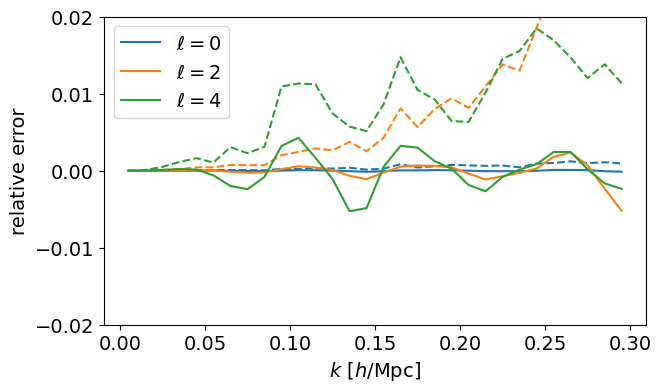

In [45]:
plt.figure(figsize=(7,4))
for i in range(3): 
    plt.plot(kd, 1-bPk_JAXBird[i]/bPk_PyBird[i], 'C%s' % i, label=r'$\ell=%s$' % (2*i))
    plt.plot(kd, 1-bPk_JAXEmu[i]/bPk_PyBird[i], 'C%s--' % i)
plt.xlabel(r'$k \ [h/{\rm Mpc}]$')
plt.ylabel(r'relative error')
plt.ylim(-.02, 0.02)
plt.legend()
plt.show()

`JAX` and `NumPy` float precision are set differently which can explain the differences between `PyBird-JAX` and `PyBird`. 

### `PyBird` interface w/ Boltzmann solvers

* Please ensure you have `CosmoPower-JAX` and `DISCO-EB` installed before running the next cells!

`CLASS`: http://class-code.net/

In [46]:
get_bPk = set_engine(with_jax=False, with_emu=False, cosmo_module='class') # class is not JAX-compatible
bPk_CLASS = get_bPk(cosmo, eft_params)
%timeit _ = get_bPk(cosmo, eft_params)

845 ms ± 121 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


`Symbolic`: https://github.com/DeaglanBartlett/symbolic_pofk

In [47]:
get_bPk = set_engine(with_jax=True, with_emu=True, cosmo_module='Symbolic')
bPk_Symbolic = get_bPk(cosmo, eft_params) # jitting
%timeit _ = get_bPk(cosmo, eft_params)

jax: on
1.6 ms ± 258 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


`CosmoPower-JAX`: https://github.com/dpiras/cosmopower-jax

In [48]:
get_bPk = set_engine(with_jax=True, with_emu=True, cosmo_module='CPJ')
bPk_CPJ = get_bPk(cosmo, eft_params) # jitting
%timeit _ = get_bPk(cosmo, eft_params)

jax: on
1.43 ms ± 110 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


`DISCO-EB`: https://github.com/ohahn/DISCO-EB

Comparison

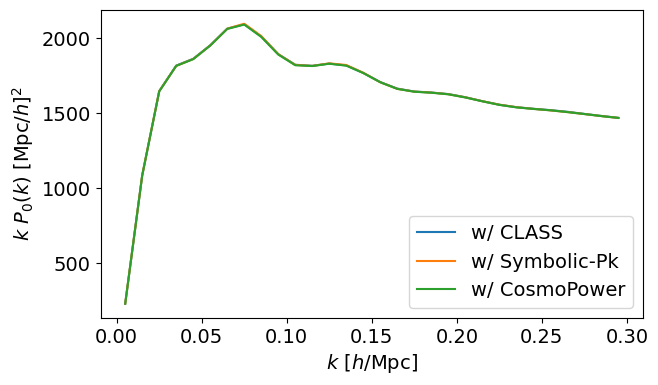

In [49]:
plt.figure(figsize=(7,4))
plt.plot(kd, kd * bPk_CLASS[0], label=r'w/ CLASS')
plt.plot(kd, kd * bPk_Symbolic[0], label=r'w/ Symbolic-Pk')
plt.plot(kd, kd * bPk_CPJ[0], label=r'w/ CosmoPower')
plt.xlabel(r'$k \ [h/{\rm Mpc}]$')
plt.ylabel(r'$k \ P_0(k) \ [{\rm Mpc}/h]^2$')
plt.legend()
plt.show()